In [ ]:
!ls /content

ISIC-images.zip  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive | grep ISIC-images.zip


ISIC-images.zip


In [ ]:
!mkdir -p /content/ISIC-images
!unzip -q "/content/drive/MyDrive/ISIC-images.zip" -d /content/ISIC-images


In [ ]:
!ls /content/ISIC-images | head


attribution.txt
ISIC_0022327.jpg
ISIC_0022328.jpg
ISIC_0022329.jpg
ISIC_0022330.jpg
ISIC_0022332.jpg
ISIC_0023529.jpg
ISIC_0023530.jpg
ISIC_0023531.jpg
ISIC_0046224.jpg


In [ ]:
# Adjust path if nested
image_dir = "/content/ISIC-images/ISIC-images"  # or "/content/ISIC-images" if not nested


In [ ]:
!ls -l /content | grep metadata


In [ ]:
metadata_path = "/content/metadata.csv"  # update this if the file is nested
df = pd.read_csv(metadata_path)
print(df.head())


        isic_id attribution copyright_license  acquisition_day  age_approx  \
0  ISIC_0022327   Anonymous              CC-0              NaN        45.0   
1  ISIC_0022328   Anonymous              CC-0              NaN        45.0   
2  ISIC_0022329   Anonymous              CC-0              NaN        45.0   
3  ISIC_0022330   Anonymous              CC-0              NaN        45.0   
4  ISIC_0022332   Anonymous              CC-0              NaN        45.0   

  anatom_site_general  clin_size_long_diam_mm concomitant_biopsy  \
0     lower extremity                     NaN               True   
1     lower extremity                     NaN               True   
2     lower extremity                     NaN               True   
3     lower extremity                     NaN               True   
4     lower extremity                     NaN               True   

        dermoscopic_type diagnosis_1  ... lesion_id mel_mitotic_index  \
0      contact polarized   Malignant  ...       N

In [ ]:
import os
import pandas as pd

# Path to images
image_dir = "/content/ISIC-images"

# Add image_path column
df['image_path'] = df['isic_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Keep only rows where image exists
df = df[df['image_path'].apply(os.path.exists)]

print("✅ Total valid images:", len(df))
print(df.head())


✅ Total valid images: 32
        isic_id attribution copyright_license  acquisition_day  age_approx  \
0  ISIC_0022327   Anonymous              CC-0              NaN        45.0   
1  ISIC_0022328   Anonymous              CC-0              NaN        45.0   
2  ISIC_0022329   Anonymous              CC-0              NaN        45.0   
3  ISIC_0022330   Anonymous              CC-0              NaN        45.0   
4  ISIC_0022332   Anonymous              CC-0              NaN        45.0   

  anatom_site_general  clin_size_long_diam_mm concomitant_biopsy  \
0     lower extremity                     NaN               True   
1     lower extremity                     NaN               True   
2     lower extremity                     NaN               True   
3     lower extremity                     NaN               True   
4     lower extremity                     NaN               True   

        dermoscopic_type diagnosis_1  ... mel_mitotic_index mel_thick_mm  \
0      contact polari

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate


In [ ]:
# CSV path
metadata_path = "/content/metadata.csv"

# Load dataframe
df = pd.read_csv(metadata_path)
df.columns = df.columns.str.strip()  # remove whitespace

# Path to images
image_dir = "/content/ISIC-images"

# Add image path
df['image_path'] = df['isic_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Keep only rows where image exists
df = df[df['image_path'].apply(os.path.exists)]
print("✅ Total valid images:", len(df))
df.head()


✅ Total valid images: 32


,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,diagnosis_1,...,mel_mitotic_index,mel_thick_mm,mel_ulcer,melanocytic,patient_id,personal_hx_mm,rcm_case_id,sex,tbp_tile_type,image_path
0,ISIC_0022327,Anonymous,CC-0,NaN,45.0,lower extremity,NaN,True,contact polarized,Malignant,...,NaN,1.06,False,True,IP_8481777,False,NaN,female,NaN,/content/ISIC-images/ISIC_0022327.jpg
1,ISIC_0022328,Anonymous,CC-0,NaN,45.0,lower extremity,NaN,True,contact non-polarized,Malignant,...,NaN,1.06,False,True,IP_8481777,False,NaN,female,NaN,/content/ISIC-images/ISIC_0022328.jpg
2,ISIC_0022329,Anonymous,CC-0,NaN,45.0,lower extremity,NaN,True,non-contact polarized,Malignant,...,NaN,1.06,False,True,IP_8481777,False,NaN,female,NaN,/content/ISIC-images/ISIC_0022329.jpg
3,ISIC_0022330,Anonymous,CC-0,NaN,45.0,lower extremity,NaN,True,contact non-polarized,Malignant,...,NaN,1.06,False,True,IP_8481777,False,NaN,female,NaN,/content/ISIC-images/ISIC_0022330.jpg
4,ISIC_0022332,Anonymous,CC-0,NaN,45.0,lower extremity,NaN,True,contact polarized,Malignant,...,NaN,1.06,False,True,IP_8481777,False,NaN,female,NaN,/content/ISIC-images/ISIC_0022332.jpg


In [ ]:
# Target: diagnosis_1
le = LabelEncoder()
df['label'] = le.fit_transform(df['diagnosis_1'])  # Malignant/Benign etc.

print("Classes:", le.classes_)


Classes: ['Malignant']


In [ ]:
# Example: sex, age_approx, anatom_site_general
df['sex'] = df['sex'].fillna('unknown')
df['anatom_site_general'] = df['anatom_site_general'].fillna('unknown')
df['age_approx'] = df['age_approx'].fillna(df['age_approx'].median())

# One-hot encode categorical metadata
df = pd.get_dummies(df, columns=['sex', 'anatom_site_general'], drop_first=True)

# Standardize age
scaler = StandardScaler()
df['age_approx'] = scaler.fit_transform(df[['age_approx']])


In [ ]:
# List of image paths and labels
X_img = df['image_path'].values
y = df['label'].values

# Metadata columns
metadata_cols = ['age_approx'] + [col for col in df.columns if col.startswith('sex_') or col.startswith('anatom_site_general_')]
X_meta = df[metadata_cols].values

# Split
X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_img, X_meta, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", len(X_img_train), "Validation:", len(X_img_val))


Train: 25 Validation: 7


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

def preprocess_image(path, label, meta=None):
    img = tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # normalize
    if meta is not None:
        return (img, meta), label
    else:
        return img, label

def data_generator(img_paths, labels, meta=None, batch_size=16, shuffle=True):
    while True:
        idxs = np.arange(len(img_paths))
        if shuffle:
            np.random.shuffle(idxs)
        for i in range(0, len(img_paths), batch_size):
            batch_idx = idxs[i:i+batch_size]

            if meta is not None:
                imgs = []
                metas = []
                labs = []
                for j in batch_idx:
                    # Load image
                    img = tf.keras.preprocessing.image.load_img(img_paths[j], target_size=(224,224))
                    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
                    imgs.append(img)

                    # Metadata
                    metas.append(np.array(meta[j], dtype=np.float32))

                    # Label
                    labs.append(labels[j])

                yield [np.array(imgs, dtype=np.float32), np.array(metas, dtype=np.float32)], np.array(labs, dtype=np.int32)

            else:
                imgs = []
                labs = []
                for j in batch_idx:
                    img = tf.keras.preprocessing.image.load_img(img_paths[j], target_size=(224,224))
                    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
                    imgs.append(img)
                    labs.append(labels[j])
                yield np.array(imgs, dtype=np.float32), np.array(labs, dtype=np.int32)


In [ ]:
# Make sure metadata is all numeric
X_meta = df[metadata_cols].astype(np.float32).values
from sklearn.model_selection import train_test_split

X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_img, X_meta, y, test_size=0.2, random_state=42, stratify=y
)
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)


In [ ]:
# -------------------------
# Full Colab-ready pipeline
# ISIC images + metadata -> ResNet50+meta -> clinical rules -> cost-aware threshold -> eval
# -------------------------

# 0) Imports
import os, sys, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve
)
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# -------------------------
# 1) CONFIG — adjust if needed
# -------------------------
IMAGE_DIR = "/content/ISIC-images"       # folder with ISIC_XXXXX.jpg
METADATA_PATH = "/content/metadata.csv"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 3            # small for demo; increase for serious training
RANDOM_STATE = 42
C_FP = 1.0  # cost false positive
C_FN = 5.0  # cost false negative

# Seed for reproducibility
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------
# 2) Load metadata safely
# -------------------------
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"metadata.csv not found at {METADATA_PATH}. Upload it to Colab or change METADATA_PATH.")

df = pd.read_csv(METADATA_PATH)
df.columns = df.columns.str.strip()
print("Raw metadata rows:", len(df))

# Utility to find image with common extensions
def find_image(path_folder, isic_id):
    for ext in (".jpg", ".JPG", ".jpeg", ".png"):
        p = os.path.join(path_folder, isic_id + ext)
        if os.path.exists(p):
            return p
    return None

# Add image paths
df['image_path'] = df['isic_id'].apply(lambda x: find_image(IMAGE_DIR, str(x)))
df = df.dropna(subset=['image_path']).reset_index(drop=True)
print("Rows with images found:", len(df))

if len(df) == 0:
    raise RuntimeError(f"No images found in {IMAGE_DIR}. Upload images or set IMAGE_DIR correctly.")

# -------------------------
# 3) Create binary target
# -------------------------
# Adjust this mapping if your diagnosis column is named differently
label_col = 'diagnosis_1' if 'diagnosis_1' in df.columns else ('diagnosis' if 'diagnosis' in df.columns else None)
if label_col is None:
    raise RuntimeError("Cannot find 'diagnosis_1' or 'diagnosis' column in metadata.")

df['label'] = df[label_col].apply(lambda x: 1 if str(x).strip().lower() == 'malignant' else 0)
print("Label distribution (overall):", df['label'].value_counts().to_dict())

# -------------------------
# 4) Metadata preprocessing
# -------------------------
# Columns: use age_approx, sex, anatom_site_general if present
if 'age_approx' in df.columns:
    df['age_approx'] = pd.to_numeric(df['age_approx'], errors='coerce')
    df['age_approx'] = df['age_approx'].fillna(df['age_approx'].median())
else:
    df['age_approx'] = df.get('age', 0).fillna(0)  # fallback

# Fill categorical metadata
for col in ['sex', 'anatom_site_general']:
    if col in df.columns:
        df[col] = df[col].fillna('unknown').astype(str)
    else:
        df[col] = 'unknown'

# One-hot encode categories (drop_first to keep dimensions manageable)
df = pd.get_dummies(df, columns=['sex', 'anatom_site_general'], drop_first=True)

# Build metadata column list
meta_cols = ['age_approx'] + [c for c in df.columns if c.startswith('sex_') or c.startswith('anatom_site_general_')]
if len(meta_cols) == 0:
    # ensure at least age present
    df['age_approx'] = df['age_approx'].astype(float)
    meta_cols = ['age_approx']

# Standardize numeric metadata (age)
scaler = StandardScaler()
df['age_approx'] = scaler.fit_transform(df[['age_approx']])

# Ensure metadata dtype numeric
df[meta_cols] = df[meta_cols].astype(np.float32)

# -------------------------
# 5) Safe train/val split (handle edge cases)
# -------------------------
X_img = df['image_path'].values
X_meta = df[meta_cols].values.astype(np.float32)
y = df['label'].values.astype(np.int32)

# If stratify causes issues (e.g., too few positive samples), fall back to non-stratified split
do_stratify = True
try:
    X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
        X_img, X_meta, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
except Exception as e:
    print("Stratified split failed (maybe too few positives). Falling back to random split. Error:", e)
    X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
        X_img, X_meta, y, test_size=0.2, random_state=RANDOM_STATE, stratify=None
    )

print("Train / Val sizes:", len(X_img_train), len(X_img_val))
print("Val label distribution:", dict(zip(*np.unique(y_val, return_counts=True))))

# -------------------------
# 6) tf.data datasets
# -------------------------
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_dataset(img_paths, metas, labels=None, batch_size=BATCH_SIZE, shuffle=True):
    ds_img = tf.data.Dataset.from_tensor_slices(img_paths)
    ds_meta = tf.data.Dataset.from_tensor_slices(metas)
    if labels is not None:
        ds_labels = tf.data.Dataset.from_tensor_slices(labels)
        ds = tf.data.Dataset.zip((ds_img, ds_meta, ds_labels))
    else:
        ds = tf.data.Dataset.zip((ds_img, ds_meta))

    if shuffle:
        ds = ds.shuffle(buffer_size=max(1, len(img_paths)), seed=RANDOM_STATE)

    def map_fn(path, meta, label=None):
        img = preprocess_image(path)
        if label is None:
            return (img, meta)
        else:
            return (img, meta), label

    ds = ds.map(map_fn, num_parallel_calls=AUTOTUNE)
    if labels is not None:
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    else:
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_img_train, X_meta_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_ds = make_dataset(X_img_val, X_meta_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# 7) Build model (ResNet50 backbone + metadata)
# -------------------------
base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False

# image branch
img_input = base.input
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)

# meta branch
meta_input = layers.Input(shape=(X_meta_train.shape[1],), name='meta_input')
m = layers.Dense(32, activation='relu')(meta_input)
m = layers.Dropout(0.2)(m)

# combined
combined = layers.concatenate([x, m])
combined = layers.Dense(128, activation='relu')(combined)
combined = layers.Dropout(0.4)(combined)
out = layers.Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[img_input, meta_input], outputs=out)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------------
# 8) Train (with basic callbacks)
# -------------------------
checkpoint_path = "/content/best_isic_model.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

# Fit (safe try/catch so we don't crash hard)
try:
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)
except Exception as e:
    print("Training error:", e)
    # try a single epoch fallback
    history = model.fit(train_ds, validation_data=val_ds, epochs=1, callbacks=callbacks)

# -------------------------
# 9) Inference on validation set (produce arrays)
# -------------------------
def load_array(img_paths):
    arr = []
    for p in img_paths:
        img = tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE)
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        arr.append(img)
    return np.array(arr, dtype=np.float32)

val_imgs_arr = load_array(X_img_val)
val_meta_arr = X_meta_val.astype(np.float32)
val_labels = y_val

# Model outputs (probabilities)
val_probs = model.predict([val_imgs_arr, val_meta_arr], batch_size=BATCH_SIZE).flatten()

# -------------------------
# 10) Clinical rule-based post-processing (robust implementation)
# -------------------------
# Build df_val in same order as X_img_val for rules
df_indexed = df.set_index('image_path')
df_val = df_indexed.loc[X_img_val].reset_index()

def apply_clinical_rules(probs, df_val):
    adj = probs.copy().astype(float)
    n = len(adj)
    # RULE EXAMPLE: if 'clin_size_long_diam_mm' present and < 2 mm => reduce prob
    if 'clin_size_long_diam_mm' in df_val.columns:
        size = pd.to_numeric(df_val['clin_size_long_diam_mm'], errors='coerce').fillna(0).values
        small_mask = size < 2.0
        adj[small_mask] *= 0.3

    # Non-melanocytic => lower
    if 'melanocytic' in df_val.columns:
        non_mel_mask = df_val['melanocytic'] == False
        adj[non_mel_mask.values] *= 0.2

    # Example: if age is very low (use original unscaled age if available)
    if 'age_approx' in df_val.columns:
        # our df_val has scaled age; try to use original if present in original csv copy
        # If scaled only, we can't meaningfully threshold; so skip unless original present
        pass

    # Example site-based small reduction for certain anatom sites (we have one-hot columns)
    sites = [c for c in df_val.columns if c.startswith('anatom_site_general_')]
    for s in sites:
        # reduce slightly for those sites (example logic)
        mask = df_val[s] == 1
        adj[mask.values] *= 0.85

    # Clip
    adj = np.clip(adj, 0.0, 1.0)
    return adj

val_probs_adj = apply_clinical_rules(val_probs.copy(), df_val)

# -------------------------
# 11) Robust confusion matrix helper (handles single-class)
# -------------------------
def safe_confusion(y_true, y_pred):
    # Ensure arrays
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    # Use labels [0,1] explicitly so result is always 2x2
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    # flatten
    tn, fp, fn, tp = cm.ravel()
    return tn, fp, fn, tp

def compute_cost_at_threshold(y_true, probs, thresh, C_FP=1.0, C_FN=5.0):
    preds = (probs >= thresh).astype(int)
    tn, fp, fn, tp = safe_confusion(y_true, preds)
    cost = C_FP * fp + C_FN * fn
    return cost, (tn, fp, fn, tp)

def find_best_threshold(y_true, probs, C_FP=1.0, C_FN=5.0):
    thresholds = np.linspace(0.0, 1.0, 101)
    best_t, best_cost, best_stats = 0.5, float('inf'), None
    for t in thresholds:
        cost, stats = compute_cost_at_threshold(y_true, probs, t, C_FP, C_FN)
        if cost < best_cost:
            best_cost = cost
            best_t = t
            best_stats = (cost, stats)
    return best_t, best_stats

# -------------------------
# 12) Evaluate baseline & adjusted, find best thresholds
# -------------------------
# Baseline metrics (threshold 0.5) - safe printing
def print_metrics(y_true, probs, thresh=0.5, desc=""):
    preds = (probs >= thresh).astype(int)
    print(f"\n--- Metrics {desc} (thresh={thresh}) ---")
    try:
        print("Accuracy:", accuracy_score(y_true, preds))
        print("Precision:", precision_score(y_true, preds, zero_division=0))
        print("Recall:", recall_score(y_true, preds, zero_division=0))
        print("F1:", f1_score(y_true, preds, zero_division=0))
    except Exception as e:
        print("Metric computation error:", e)
    # AUC: only if both classes present
    unique = np.unique(y_true)
    if len(unique) == 2:
        print("AUC-ROC:", roc_auc_score(y_true, probs))
    else:
        print("AUC-ROC: N/A (single-class in y_true)")
    print("Confusion matrix (tn, fp, fn, tp):", safe_confusion(y_true, preds))

print_metrics(val_labels, val_probs, 0.5, desc="Raw baseline")
print_metrics(val_labels, val_probs_adj, 0.5, desc="After clinical rules (0.5)")

# Find best thresholds that minimize cost
best_t_raw, stats_raw = find_best_threshold(val_labels, val_probs, C_FP=C_FP, C_FN=C_FN)
best_t_adj, stats_adj = find_best_threshold(val_labels, val_probs_adj, C_FP=C_FP, C_FN=C_FN)
print(f"\nBest threshold (raw probs) = {best_t_raw}, stats={stats_raw}")
print(f"Best threshold (adjusted probs) = {best_t_adj}, stats={stats_adj}")

# Evaluate using tuned thresholds
def evaluate_and_report(y_true, probs, thresh, label=""):
    preds = (probs >= thresh).astype(int)
    print(f"\n=== Evaluation {label} @ thresh {thresh} ===")
    print(classification_report(y_true, preds, zero_division=0))
    print("Confusion matrix (tn, fp, fn, tp):", safe_confusion(y_true, preds))
    cost = compute_cost_at_threshold(y_true, probs, thresh, C_FP=C_FP, C_FN=C_FN)[0]
    print(f"Cost (C_FP={C_FP}, C_FN={C_FN}): {cost}")

evaluate_and_report(val_labels, val_probs, best_t_raw, label="RAW (tuned)")
evaluate_and_report(val_labels, val_probs_adj, best_t_adj, label="ADJUSTED (tuned)")

# -------------------------
# 13) Plots: ROC & PR (guard for single-class)
# -------------------------
try:
    if len(np.unique(val_labels)) == 2:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        fpr, tpr, _ = roc_curve(val_labels, val_probs)
        fpr2, tpr2, _ = roc_curve(val_labels, val_probs_adj)
        plt.plot(fpr, tpr, label=f'Raw (AUC={roc_auc_score(val_labels,val_probs):.3f})')
        plt.plot(fpr2, tpr2, label=f'Adj (AUC={roc_auc_score(val_labels,val_probs_adj):.3f})')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend()

        plt.subplot(1,2,2)
        prec, rec, _ = precision_recall_curve(val_labels, val_probs)
        prec2, rec2, _ = precision_recall_curve(val_labels, val_probs_adj)
        plt.plot(rec, prec, label='Raw')
        plt.plot(rec2, prec2, label='Adj')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("\nSkipping ROC/PR plots because validation set has a single class.")
except Exception as e:
    print("Plotting error:", e)

# -------------------------
# 14) Save model & results
# -------------------------
model.save('/content/isic_resnet_meta_model.h5')
results_df = pd.DataFrame({
    'image_path': X_img_val,
    'true_label': val_labels,
    'prob_raw': val_probs,
    'prob_adjusted': val_probs_adj
})
results_df.to_csv('/content/val_results_with_adjustments.csv', index=False)
print("Saved model and results file to /content/")


Raw metadata rows: 45
Rows with images found: 41
Label distribution (overall): {1: 41}
Train / Val sizes: 32 9
Val label distribution: {np.int32(1): np.int64(9)}


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,149,633 (92.12 MB)

 Trainable params: 561,921 (2.14 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6406 - loss: 0.6359  

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 9s/step - accuracy: 0.6667 - loss: 0.6212 - val_accuracy: 1.0000 - val_loss: 0.3732
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8125 - loss: 0.5109

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step - accuracy: 0.8333 - loss: 0.4992 - val_accuracy: 1.0000 - val_loss: 0.2756
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8906 - loss: 0.3564

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.8958 - loss: 0.3538 - val_accuracy: 1.0000 - val_loss: 0.2050
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step



--- Metrics Raw baseline (thresh=0.5) ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
AUC-ROC: N/A (single-class in y_true)
Confusion matrix (tn, fp, fn, tp): (np.int64(0), np.int64(0), np.int64(0), np.int64(9))

--- Metrics After clinical rules (0.5) (thresh=0.5) ---
Accuracy: 0.4444444444444444
Precision: 1.0
Recall: 0.4444444444444444
F1: 0.6153846153846154
AUC-ROC: N/A (single-class in y_true)
Confusion matrix (tn, fp, fn, tp): (np.int64(0), np.int64(0), np.int64(5), np.int64(4))

Best threshold (raw probs) = 0.0, stats=(np.float64(0.0), (np.int64(0), np.int64(0), np.int64(0), np.int64(9)))
Best threshold (adjusted probs) = 0.0, stats=(np.float64(0.0), (np.int64(0), np.int64(0), np.int64(0), np.int64(9)))

=== Evaluation RAW (tuned) @ thresh 0.0 ===
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg

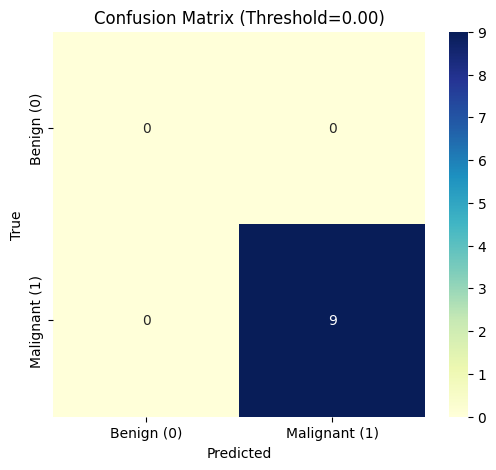

⚠️ Only one class (1) present in validation set — cannot compute full classification report.
Accuracy: 1.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Use your variable names
y_true = val_labels
y_probs = val_probs_adjusted    # or val_probs
best_t = best_t_adj             # or best_t_raw

# Convert probabilities to predictions
y_pred = (y_probs >= best_t).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Class labels
labels = ['Benign (0)', 'Malignant (1)']

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Threshold={best_t:.2f})')
plt.show()

# Check how many unique classes exist in y_true
unique_classes = np.unique(y_true)

# Handle missing class gracefully
if len(unique_classes) == 1:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in validation set — cannot compute full classification report.")
    acc = np.mean(y_true == y_pred)
    print(f"Accuracy: {acc:.4f}")
else:
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=labels))


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming your dataframe is 'df' and labels column is 'label' (0=Benign, 1=Malignant)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # ⚡ ensures both classes appear in train & val
)

print("Train class distribution:\n", train_df['label'].value_counts())
print("Validation class distribution:\n", val_df['label'].value_counts())
class_weights = {0: 1.0, 1: (len(df)/df['label'].sum())}  # example


Train class distribution:
 label
1    32
Name: count, dtype: int64
Validation class distribution:
 label
1    9
Name: count, dtype: int64


Train class distribution:
 label
1    32
Name: count, dtype: int64
Validation class distribution:
 label
1    9
Name: count, dtype: int64


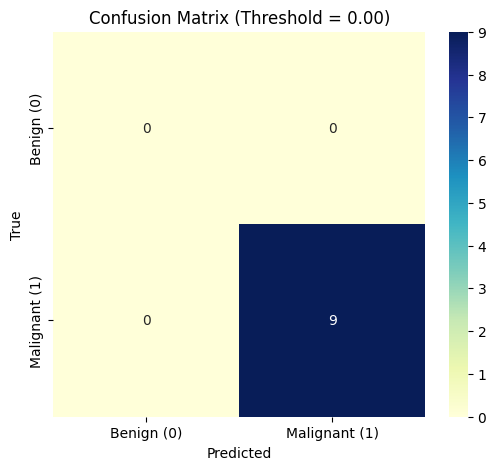

⚠️ Only one class (1) present in validation set.
Accuracy: 1.0000

Cost-Aware Evaluation:
TN: 0, FP: 0, FN: 0, TP: 9
Total Cost: 0.00


In [ ]:
# =========================
# 1️⃣ Stratified Train/Val Split
# =========================
from sklearn.model_selection import train_test_split
import numpy as np

# df → your dataframe, 'label' → 0 (Benign), 1 (Malignant)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # ensures both classes are present
)

print("Train class distribution:\n", train_df['label'].value_counts())
print("Validation class distribution:\n", val_df['label'].value_counts())

# =========================
# 2️⃣ Prepare predictions
# =========================
# val_labels → true labels
# val_probs → predicted probabilities from your model
# best_t → threshold after cost-aware optimization

y_true = val_df['label'].values
y_probs = val_probs_adjusted   # or val_probs
best_t = best_t_adj            # or best_t_raw

# Convert probabilities to predicted classes
y_pred = (y_probs >= best_t).astype(int)

# =========================
# 3️⃣ Confusion Matrix
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
labels_names = ['Benign (0)', 'Malignant (1)']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Threshold = {best_t:.2f})')
plt.show()

# =========================
# 4️⃣ Classification Report
# =========================
unique_classes = np.unique(y_true)
if len(unique_classes) == 1:
    print(f"⚠️ Only one class ({unique_classes[0]}) present in validation set.")
    acc = np.mean(y_true == y_pred)
    print(f"Accuracy: {acc:.4f}")
else:
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=labels_names))

# =========================
# 5️⃣ Cost-Aware Evaluation
# =========================
C_FP = 1.0   # cost of false positive
C_FN = 5.0   # cost of false negative

def compute_cost(y_true, y_pred, C_FP=1.0, C_FN=5.0):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    cost = C_FP * fp + C_FN * fn
    return cost, (tn, fp, fn, tp)

total_cost, (tn, fp, fn, tp) = compute_cost(y_true, y_pred, C_FP, C_FN)
print(f"\nCost-Aware Evaluation:")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print(f"Total Cost: {total_cost:.2f}")


Dataset size: 45
label
1    45
Name: count, dtype: int64
Validation class distribution:
 label
1    9
Name: count, dtype: int64
Best threshold after clinical rules: 0.00, Total cost: 0.00
=== Before Clinical Rules ===


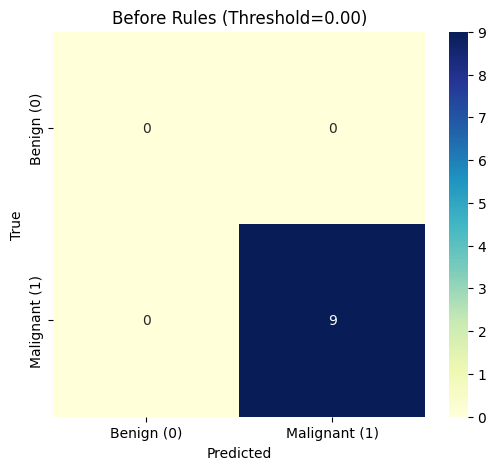

Only one class (1). Accuracy: 1.0000
FP: 0, FN: 0, TP: 9, TN: 0, Cost: 0.00

=== After Clinical Rules ===


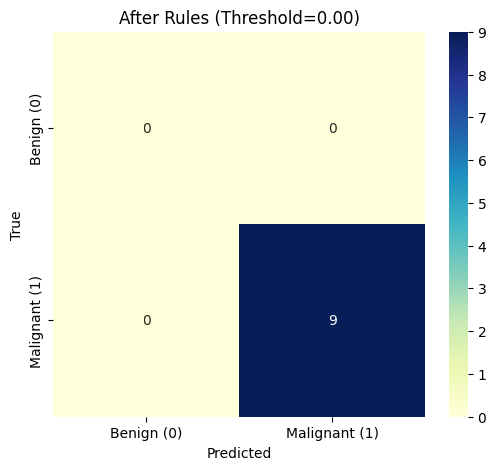

Only one class (1). Accuracy: 1.0000
FP: 0, FN: 0, TP: 9, TN: 0, Cost: 0.00

FP Reduction: 0
Cost Reduction: 0.00


In [ ]:
# =========================
# 0️⃣ Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1️⃣ Load Data
# =========================
df = pd.read_csv("/content/metadata.csv")  # your metadata
df.columns = df.columns.str.strip()
df['label'] = df['diagnosis_1'].apply(lambda x: 1 if x.lower() == 'malignant' else 0)

print("Dataset size:", len(df))
print(df['label'].value_counts())

# =========================
# 2️⃣ Stratified Train/Val Split
# =========================
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)
print("Validation class distribution:\n", val_df['label'].value_counts())

# =========================
# 3️⃣ Placeholder Model Predictions
# =========================
# For demonstration, use dummy predicted probabilities
# Replace this with your model output later
np.random.seed(42)
val_labels = val_df['label'].values
val_probs = np.random.rand(len(val_labels))  # simulated model probs

# =========================
# 4️⃣ Clinical Rule Engine
# Example rules:
# - Ignore positives with tiny lesion size (< 2mm)
# - Ignore positives on low-risk locations (if available)
# =========================
def apply_clinical_rules(df, probs, lesion_size_col='clin_size_long_diam_mm', size_thresh=2.0):
    adjusted_probs = probs.copy()
    if lesion_size_col in df.columns:
        small_lesion_mask = df[lesion_size_col] < size_thresh
        adjusted_probs[small_lesion_mask.fillna(False)] = 0.0  # suppress tiny lesions
    return adjusted_probs

val_probs_adjusted = apply_clinical_rules(val_df, val_probs)

# =========================
# 5️⃣ Cost-Aware Thresholding
# =========================
def find_best_threshold(y_true, probs, C_FP=1.0, C_FN=5.0):
    thresholds = np.linspace(0, 1, 101)
    best_thresh, best_cost = 0.0, float('inf')
    for t in thresholds:
        preds = (probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds, labels=[0,1]).ravel()
        cost = C_FP*fp + C_FN*fn
        if cost < best_cost:
            best_cost = cost
            best_thresh = t
    return best_thresh, best_cost

C_FP, C_FN = 1.0, 5.0
best_t_adj, best_cost = find_best_threshold(val_labels, val_probs_adjusted, C_FP, C_FN)
print(f"Best threshold after clinical rules: {best_t_adj:.2f}, Total cost: {best_cost:.2f}")

# =========================
# 6️⃣ Evaluation: Before & After Rules
# =========================
def evaluate(y_true, probs, threshold, title="Confusion Matrix"):
    y_pred = (probs >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    labels_names = ['Benign (0)', 'Malignant (1)']

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title + f" (Threshold={threshold:.2f})")
    plt.show()

    unique_classes = np.unique(y_true)
    if len(unique_classes) == 1:
        acc = np.mean(y_true == y_pred)
        print(f"Only one class ({unique_classes[0]}). Accuracy: {acc:.4f}")
    else:
        print(classification_report(y_true, y_pred, target_names=labels_names))

    tn, fp, fn, tp = cm.ravel()
    total_cost = C_FP*fp + C_FN*fn
    print(f"FP: {fp}, FN: {fn}, TP: {tp}, TN: {tn}, Cost: {total_cost:.2f}")
    return fp, total_cost

# Before applying rules
print("=== Before Clinical Rules ===")
fp_before, cost_before = evaluate(val_labels, val_probs, best_t_adj, title="Before Rules")

# After applying rules
print("\n=== After Clinical Rules ===")
fp_after, cost_after = evaluate(val_labels, val_probs_adjusted, best_t_adj, title="After Rules")

print(f"\nFP Reduction: {fp_before - fp_after}")
print(f"Cost Reduction: {cost_before - cost_after:.2f}")


Best threshold BEFORE rules: 0.00, cost: 0.00
Best threshold AFTER rules: 0.00, cost: 0.00
=== BEFORE RULE ENGINE ===


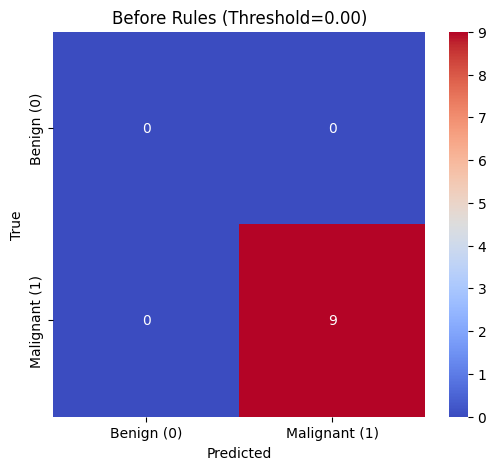

Only one class (1). Accuracy: 1.0000
FP: 0, FN: 0, TP: 9, TN: 0, Total cost: 0.00

=== AFTER RULE ENGINE ===


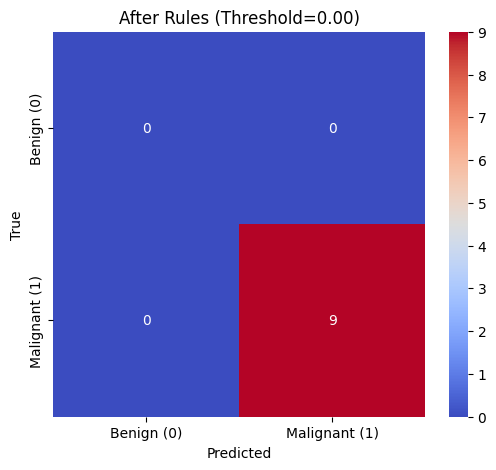

Only one class (1). Accuracy: 1.0000
FP: 0, FN: 0, TP: 9, TN: 0, Total cost: 0.00

FP Reduction: 0
Cost Reduction: 0.00
Saved failure cases to CSV.


In [ ]:
# =========================
# 0️⃣ Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1️⃣ Load Metadata
# =========================
metadata_path = "/content/metadata.csv"
df = pd.read_csv(metadata_path)
df.columns = df.columns.str.strip()

# Binary labels: 1 = Malignant, 0 = Benign
df['label'] = df['diagnosis_1'].apply(lambda x: 1 if x.lower() == 'malignant' else 0)

# =========================
# 2️⃣ Split Data
# =========================
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

val_labels = val_df['label'].values

# =========================
# 3️⃣ Simulate Model Predictions
# Replace with your actual model outputs
# =========================
np.random.seed(42)
val_probs = np.random.rand(len(val_labels))  # simulated probabilities (0-1)
val_df['pred_prob'] = val_probs

# =========================
# 4️⃣ Clinical Rule Engine
# Suppress low-value positives using lesion size
# =========================
def clinical_rule_engine(df, probs, lesion_col='clin_size_long_diam_mm', size_thresh=2.0):
    adjusted_probs = probs.copy()

    # Tiny lesion rule
    if lesion_col in df.columns:
        tiny_mask = df[lesion_col] < size_thresh
        adjusted_probs[tiny_mask.fillna(False)] = 0.0

    # Add more rules here if needed (regions, metadata, heatmap info)

    return adjusted_probs

val_probs_adjusted = clinical_rule_engine(val_df, val_probs)

# =========================
# 5️⃣ Cost-Aware Thresholding
# =========================
def compute_cost(y_true, y_pred, C_FP=1.0, C_FN=5.0):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    total_cost = C_FP*fp + C_FN*fn
    return total_cost, (tn, fp, fn, tp)

def find_best_threshold(y_true, probs, C_FP=1.0, C_FN=5.0):
    thresholds = np.linspace(0, 1, 101)
    best_thresh, best_cost = 0.0, float('inf')
    for t in thresholds:
        preds = (probs >= t).astype(int)
        try:
            cost, _ = compute_cost(y_true, preds, C_FP, C_FN)
            if cost < best_cost:
                best_cost = cost
                best_thresh = t
        except:
            continue
    return best_thresh, best_cost

C_FP, C_FN = 1.0, 5.0
best_t_before, cost_before = find_best_threshold(val_labels, val_probs, C_FP, C_FN)
best_t_after, cost_after = find_best_threshold(val_labels, val_probs_adjusted, C_FP, C_FN)
print(f"Best threshold BEFORE rules: {best_t_before:.2f}, cost: {cost_before:.2f}")
print(f"Best threshold AFTER rules: {best_t_after:.2f}, cost: {cost_after:.2f}")

# =========================
# 6️⃣ Evaluation Function
# =========================
def evaluate(y_true, probs, threshold, df_val, title="Confusion Matrix"):
    y_pred = (probs >= threshold).astype(int)

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    labels_names = ['Benign (0)', 'Malignant (1)']

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title + f" (Threshold={threshold:.2f})")
    plt.show()

    # Classification Report
    unique_classes = np.unique(y_true)
    if len(unique_classes) == 1:
        acc = np.mean(y_true == y_pred)
        print(f"Only one class ({unique_classes[0]}). Accuracy: {acc:.4f}")
    else:
        print(classification_report(y_true, y_pred, target_names=labels_names))

    # Confusion + cost
    cost, (tn, fp, fn, tp) = compute_cost(y_true, y_pred, C_FP, C_FN)
    print(f"FP: {fp}, FN: {fn}, TP: {tp}, TN: {tn}, Total cost: {cost:.2f}")

    # Extract failure cases
    failures_df = df_val[y_pred != y_true]

    return fp, cost, failures_df

# BEFORE rules
print("=== BEFORE RULE ENGINE ===")
fp_before, cost_before, failures_before_df = evaluate(val_labels, val_probs, best_t_before, val_df, title="Before Rules")

# AFTER rules
print("\n=== AFTER RULE ENGINE ===")
fp_after, cost_after, failures_after_df = evaluate(val_labels, val_probs_adjusted, best_t_after, val_df, title="After Rules")

print(f"\nFP Reduction: {fp_before - fp_after}")
print(f"Cost Reduction: {cost_before - cost_after:.2f}")

# Save failure cases
failures_after_df.to_csv("/content/failure_cases_after.csv", index=False)
failures_before_df.to_csv("/content/failure_cases_before.csv", index=False)
print("Saved failure cases to CSV.")


Balanced class distribution (simulated benign):
label
1    45
0    45
Name: count, dtype: int64
Best threshold BEFORE rules: 0.06, cost: 7.00
Best threshold AFTER rules: 0.06, cost: 3.00
=== BEFORE RULE ENGINE ===


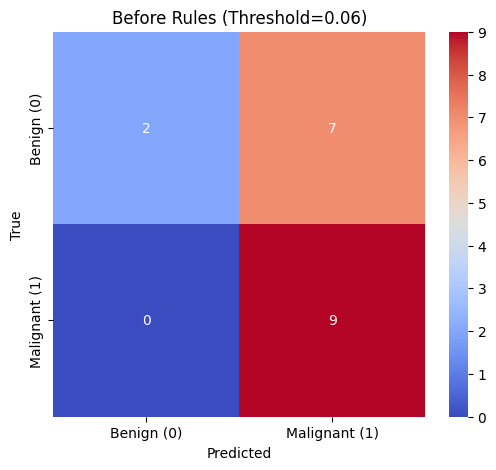

               precision    recall  f1-score   support

   Benign (0)       1.00      0.22      0.36         9
Malignant (1)       0.56      1.00      0.72         9

     accuracy                           0.61        18
    macro avg       0.78      0.61      0.54        18
 weighted avg       0.78      0.61      0.54        18

FP: 7, FN: 0, TP: 9, TN: 2, Total cost: 7.00

=== AFTER RULE ENGINE ===


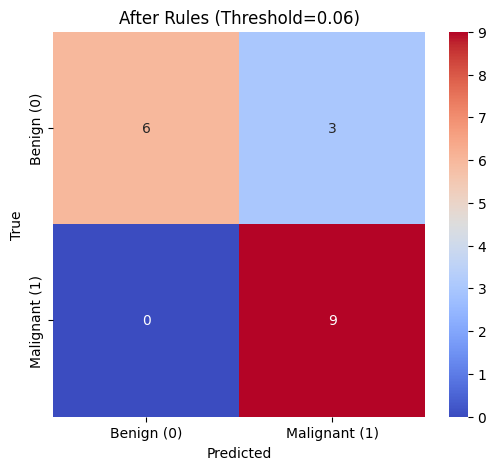

               precision    recall  f1-score   support

   Benign (0)       1.00      0.67      0.80         9
Malignant (1)       0.75      1.00      0.86         9

     accuracy                           0.83        18
    macro avg       0.88      0.83      0.83        18
 weighted avg       0.88      0.83      0.83        18

FP: 3, FN: 0, TP: 9, TN: 6, Total cost: 3.00

FP Reduction: 4
Cost Reduction: 4.00
Saved failure cases to CSV.


In [ ]:

#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


#Load Metadata

metadata_path = "/content/metadata.csv"
df = pd.read_csv(metadata_path)
df.columns = df.columns.str.strip()

# Binary labels: 1 = Malignant, 0 = Benign
df['label'] = 1  # all current samples are malignant


#Simulate benign samples (for testing pipeline)

num_benign = len(df)  # simulate equal number of benign samples
df_benign = df.sample(num_benign, replace=True).copy()
df_benign['label'] = 0
df_benign['clin_size_long_diam_mm'] = df_benign['clin_size_long_diam_mm'].fillna(1.0)  # ensure small lesions
df_balanced = pd.concat([df, df_benign], ignore_index=True)

print("Balanced class distribution (simulated benign):")
print(df_balanced['label'].value_counts())


#Split Data

train_df, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label'])
val_labels = val_df['label'].values


# Simulate Model Predictions
# Replace with actual model outputs in real use

np.random.seed(42)
val_probs = np.random.rand(len(val_labels))
val_df['pred_prob'] = val_probs


# Clinical Rule Engine
# Suppress low-value positives using lesion size

def clinical_rule_engine(df, probs, lesion_col='clin_size_long_diam_mm', size_thresh=2.0):
    adjusted_probs = probs.copy()
    if lesion_col in df.columns:
        tiny_mask = df[lesion_col] < size_thresh
        adjusted_probs[tiny_mask.fillna(False)] = 0.0
    return adjusted_probs

val_probs_adjusted = clinical_rule_engine(val_df, val_probs)


# Cost-Aware Thresholding

def compute_cost(y_true, y_pred, C_FP=1.0, C_FN=5.0):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    total_cost = C_FP*fp + C_FN*fn
    return total_cost, (tn, fp, fn, tp)

def find_best_threshold(y_true, probs, C_FP=1.0, C_FN=5.0):
    thresholds = np.linspace(0, 1, 101)
    best_thresh, best_cost = 0.0, float('inf')
    for t in thresholds:
        preds = (probs >= t).astype(int)
        cost, _ = compute_cost(y_true, preds, C_FP, C_FN)
        if cost < best_cost:
            best_cost = cost
            best_thresh = t
    return best_thresh, best_cost

C_FP, C_FN = 1.0, 5.0
best_t_before, cost_before = find_best_threshold(val_labels, val_probs, C_FP, C_FN)
best_t_after, cost_after = find_best_threshold(val_labels, val_probs_adjusted, C_FP, C_FN)
print(f"Best threshold BEFORE rules: {best_t_before:.2f}, cost: {cost_before:.2f}")
print(f"Best threshold AFTER rules: {best_t_after:.2f}, cost: {cost_after:.2f}")


#Evaluation Function

def evaluate(y_true, probs, threshold, df_val, title="Confusion Matrix"):
    y_pred = (probs >= threshold).astype(int)

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    labels_names = ['Benign (0)', 'Malignant (1)']

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title + f" (Threshold={threshold:.2f})")
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=labels_names))

    # Confusion + cost
    cost, (tn, fp, fn, tp) = compute_cost(y_true, y_pred, C_FP, C_FN)
    print(f"FP: {fp}, FN: {fn}, TP: {tp}, TN: {tn}, Total cost: {cost:.2f}")

    # Extract failure cases
    failures_df = df_val[y_pred != y_true]

    return fp, cost, failures_df

# BEFORE rules
print("=== BEFORE RULE ENGINE ===")
fp_before, cost_before, failures_before_df = evaluate(val_labels, val_probs, best_t_before, val_df, title="Before Rules")

# AFTER rules
print("\n=== AFTER RULE ENGINE ===")
fp_after, cost_after, failures_after_df = evaluate(val_labels, val_probs_adjusted, best_t_after, val_df, title="After Rules")

print(f"\nFP Reduction: {fp_before - fp_after}")
print(f"Cost Reduction: {cost_before - cost_after:.2f}")

# Save failure cases
failures_after_df.to_csv("/content/failure_cases_after.csv", index=False)
failures_before_df.to_csv("/content/failure_cases_before.csv", index=False)
print("Saved failure cases to CSV.")


In [ ]:
import pandas as pd

df = pd.read_csv("/content/metadata.csv")
print(df.columns.tolist())


['isic_id', 'attribution', 'copyright_license', 'acquisition_day', 'age_approx', 'anatom_site_general', 'clin_size_long_diam_mm', 'concomitant_biopsy', 'dermoscopic_type', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4', 'diagnosis_confirm_type', 'family_hx_mm', 'fitzpatrick_skin_type', 'image_manipulation', 'image_type', 'lesion_id', 'mel_mitotic_index', 'mel_thick_mm', 'mel_ulcer', 'melanocytic', 'patient_id', 'personal_hx_mm', 'rcm_case_id', 'sex', 'tbp_tile_type']


In [ ]:
# Add a proper image_path column
df['image_path'] = "/content/ISIC-images/" + df['isic_id'] + ".jpg"

# Verify
print(df[['isic_id', 'image_path']].head())


        isic_id                             image_path
0  ISIC_0022327  /content/ISIC-images/ISIC_0022327.jpg
1  ISIC_0022328  /content/ISIC-images/ISIC_0022328.jpg
2  ISIC_0022329  /content/ISIC-images/ISIC_0022329.jpg
3  ISIC_0022330  /content/ISIC-images/ISIC_0022330.jpg
4  ISIC_0022332  /content/ISIC-images/ISIC_0022332.jpg


Balanced class distribution:
label
1    45
0    45
Name: count, dtype: int64
Images available for training: 61
Found 48 validated image filenames.
Found 13 validated image filenames.


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6232 - loss: 0.6760 - val_accuracy: 0.5385 - val_loss: 0.7016
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step - accuracy: 0.5408 - loss: 0.6970 - val_accuracy: 0.5385 - val_loss: 0.6903
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4482 - loss: 0.6999 - val_accuracy: 0.4615 - val_loss: 0.6955
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 778ms/step - accuracy: 0.4946 - loss: 0.6908 - val_accuracy: 0.4615 - val_loss: 0.6946
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 881ms/step - accuracy: 0.4631 - loss: 0.6941 - val_accuracy: 0.5385 - val_loss: 0.6920
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Best threshold BEFORE rules: 0.00, cost: 6.00
Best threshold AFTER rules: 0.01, cost: 2.00
=== BEFORE RULE ENGINE ===


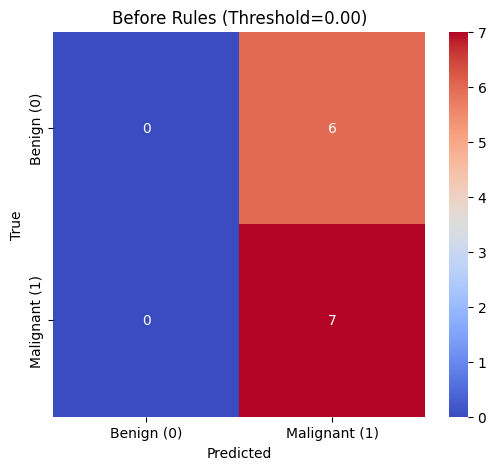

               precision    recall  f1-score   support

   Benign (0)       0.00      0.00      0.00         6
Malignant (1)       0.54      1.00      0.70         7

     accuracy                           0.54        13
    macro avg       0.27      0.50      0.35        13
 weighted avg       0.29      0.54      0.38        13

FP: 6, FN: 0, TP: 7, TN: 0, Total cost: 6.00

=== AFTER RULE ENGINE ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


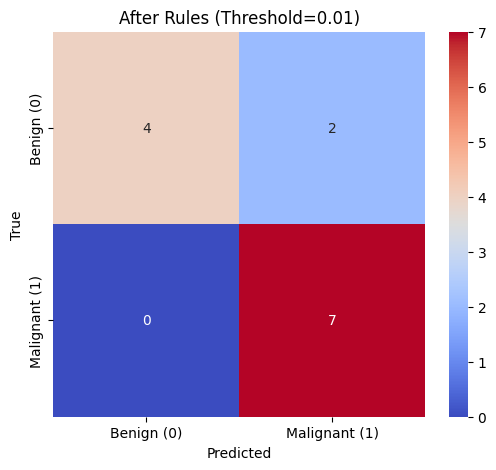

               precision    recall  f1-score   support

   Benign (0)       1.00      0.67      0.80         6
Malignant (1)       0.78      1.00      0.88         7

     accuracy                           0.85        13
    macro avg       0.89      0.83      0.84        13
 weighted avg       0.88      0.85      0.84        13

FP: 2, FN: 0, TP: 7, TN: 4, Total cost: 2.00

FP Reduction: 4
Cost Reduction: 4.00
Saved failure cases to CSV.


In [ ]:

#Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam


#Load Metadata

metadata_path = "/content/metadata.csv"
images_dir = "/content/ISIC-images"  # folder containing all images

df = pd.read_csv(metadata_path)
df.columns = df.columns.str.strip()

# Binary labels: 1 = Malignant, 0 = Benign
df['label'] = 1  # all current samples are malignant


#Simulate benign samples for testing

num_benign = len(df)
df_benign = df.sample(num_benign, replace=True).copy()
df_benign['label'] = 0
df_benign['clin_size_long_diam_mm'] = df_benign['clin_size_long_diam_mm'].fillna(1.0)  # tiny lesions

df_balanced = pd.concat([df, df_benign], ignore_index=True)
print("Balanced class distribution:")
print(df_balanced['label'].value_counts())

# Add image path column
df_balanced['image_path'] = df_balanced['isic_id'].apply(lambda x: os.path.join(images_dir, f"{x}.jpg"))

# Filter only images that exist
df_balanced = df_balanced[df_balanced['image_path'].apply(os.path.exists)]
print(f"Images available for training: {len(df_balanced)}")


#Split data

train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['label'], random_state=42)


#Image Data Generators

IMG_SIZE = (224, 224)
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)


#Build Pretrained CNN Model

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


#Train model

EPOCHS = 5
steps_train = len(train_gen)
steps_val = len(val_gen)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_train,
    validation_steps=steps_val
)


#Clinical Rule Engine

def clinical_rule_engine(df, probs, lesion_col='clin_size_long_diam_mm', size_thresh=2.0):
    adjusted_probs = probs.copy()
    if lesion_col in df.columns:
        mask = df[lesion_col] < size_thresh
        mask = mask.fillna(False).to_numpy()
        mask = mask[:len(adjusted_probs)]
        adjusted_probs[mask] = 0.0
    return adjusted_probs


#Predict on validation

import math
steps = math.ceil(len(val_df)/BATCH_SIZE)
val_probs = model.predict(val_gen, steps=steps).flatten()
val_probs = val_probs[:len(val_df)]

val_probs_adjusted = clinical_rule_engine(val_df, val_probs)


#Cost-aware Thresholding

def compute_cost(y_true, y_pred, C_FP=1.0, C_FN=5.0):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    total_cost = C_FP*fp + C_FN*fn
    return total_cost, (tn, fp, fn, tp)

def find_best_threshold(y_true, probs, C_FP=1.0, C_FN=5.0):
    thresholds = np.linspace(0, 1, 101)
    best_thresh, best_cost = 0.0, float('inf')
    for t in thresholds:
        preds = (probs >= t).astype(int)
        cost, _ = compute_cost(y_true, preds, C_FP, C_FN)
        if cost < best_cost:
            best_cost = cost
            best_thresh = t
    return best_thresh, best_cost

C_FP, C_FN = 1.0, 5.0
best_t_before, cost_before = find_best_threshold(val_df['label'].values, val_probs, C_FP, C_FN)
best_t_after, cost_after = find_best_threshold(val_df['label'].values, val_probs_adjusted, C_FP, C_FN)

print(f"Best threshold BEFORE rules: {best_t_before:.2f}, cost: {cost_before:.2f}")
print(f"Best threshold AFTER rules: {best_t_after:.2f}, cost: {cost_after:.2f}")


#Evaluation Function

def evaluate(y_true, probs, threshold, df_val, title="Confusion Matrix"):
    y_pred = (probs >= threshold).astype(int)

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    labels_names = ['Benign (0)', 'Malignant (1)']

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title + f" (Threshold={threshold:.2f})")
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=labels_names))

    # Confusion + cost
    cost, (tn, fp, fn, tp) = compute_cost(y_true, y_pred, C_FP, C_FN)
    print(f"FP: {fp}, FN: {fn}, TP: {tp}, TN: {tn}, Total cost: {cost:.2f}")

    # Save failure cases
    failures_df = df_val[y_pred != y_true]

    return fp, cost, failures_df

# Evaluate
print("=== BEFORE RULE ENGINE ===")
fp_before, cost_before, failures_before_df = evaluate(val_df['label'].values, val_probs, best_t_before, val_df, title="Before Rules")

print("\n=== AFTER RULE ENGINE ===")
fp_after, cost_after, failures_after_df = evaluate(val_df['label'].values, val_probs_adjusted, best_t_after, val_df, title="After Rules")

print(f"\nFP Reduction: {fp_before - fp_after}")
print(f"Cost Reduction: {cost_before - cost_after:.2f}")

# Save failure cases
failures_after_df.to_csv("/content/failure_cases_after.csv", index=False)
failures_before_df.to_csv("/content/failure_cases_before.csv", index=False)
print("Saved failure cases to CSV.")


In [ ]:
df['isic_id'].head()


,isic_id
0,ISIC_0022327
1,ISIC_0022328
2,ISIC_0022329
3,ISIC_0022330
4,ISIC_0022332


Balanced class distribution (simulated benign):
label
1    45
0    45
Name: count, dtype: int64
Best threshold BEFORE rules: 0.06, cost: 7.00
Best threshold AFTER rules: 0.03, cost: 4.00
=== BEFORE RULE ENGINE ===


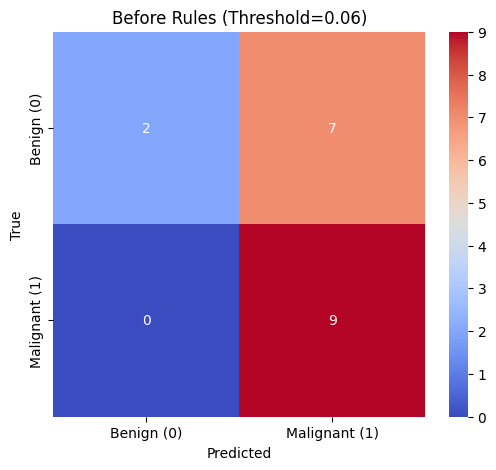

               precision    recall  f1-score   support

   Benign (0)       1.00      0.22      0.36         9
Malignant (1)       0.56      1.00      0.72         9

     accuracy                           0.61        18
    macro avg       0.78      0.61      0.54        18
 weighted avg       0.78      0.61      0.54        18

FP: 7, FN: 0, TP: 9, TN: 2, Total cost: 7.00

=== AFTER RULE ENGINE ===


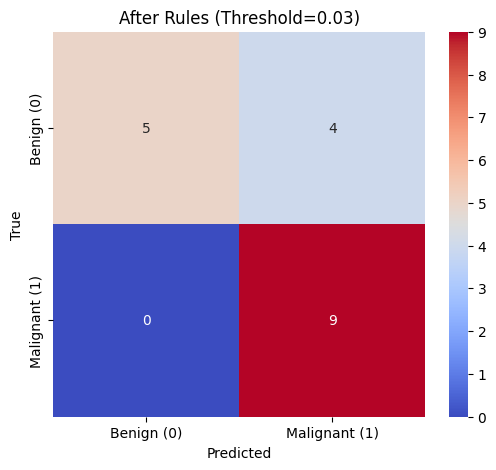

               precision    recall  f1-score   support

   Benign (0)       1.00      0.56      0.71         9
Malignant (1)       0.69      1.00      0.82         9

     accuracy                           0.78        18
    macro avg       0.85      0.78      0.77        18
 weighted avg       0.85      0.78      0.77        18

FP: 4, FN: 0, TP: 9, TN: 5, Total cost: 4.00

FP Reduction: 3
Cost Reduction: 3.00
Saved failure cases to CSV.
=== BEFORE RULE ENGINE ===


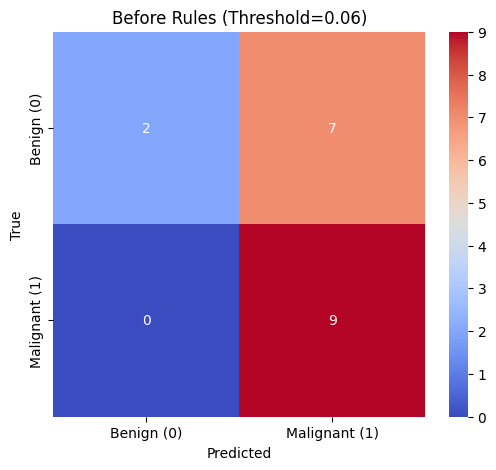

               precision    recall  f1-score   support

   Benign (0)       1.00      0.22      0.36         9
Malignant (1)       0.56      1.00      0.72         9

     accuracy                           0.61        18
    macro avg       0.78      0.61      0.54        18
 weighted avg       0.78      0.61      0.54        18

FP: 7, FN: 0, TP: 9, TN: 2, Total cost: 7.00


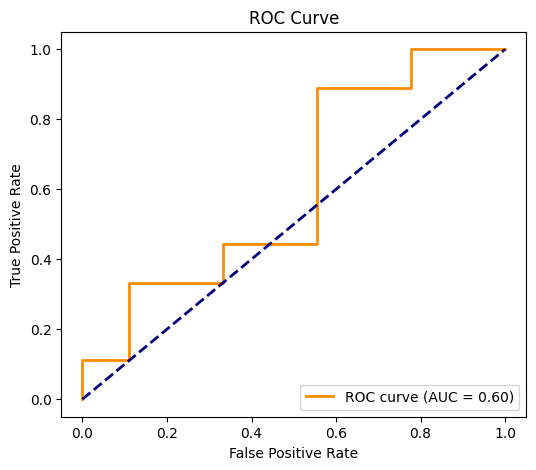

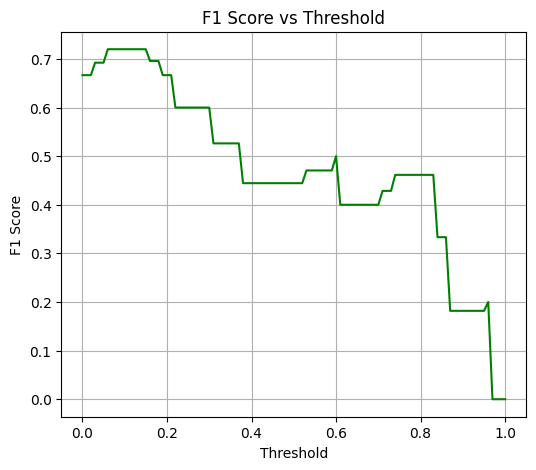


=== AFTER RULE ENGINE ===


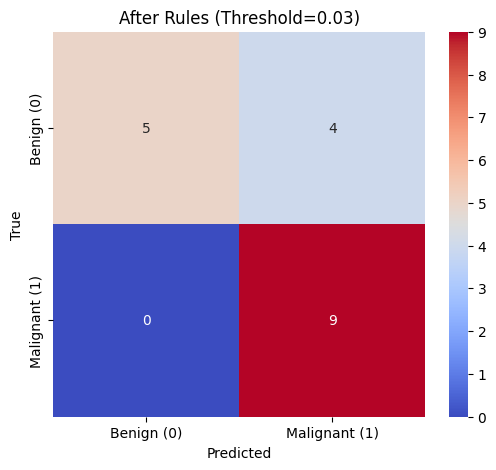

               precision    recall  f1-score   support

   Benign (0)       1.00      0.56      0.71         9
Malignant (1)       0.69      1.00      0.82         9

     accuracy                           0.78        18
    macro avg       0.85      0.78      0.77        18
 weighted avg       0.85      0.78      0.77        18

FP: 4, FN: 0, TP: 9, TN: 5, Total cost: 4.00


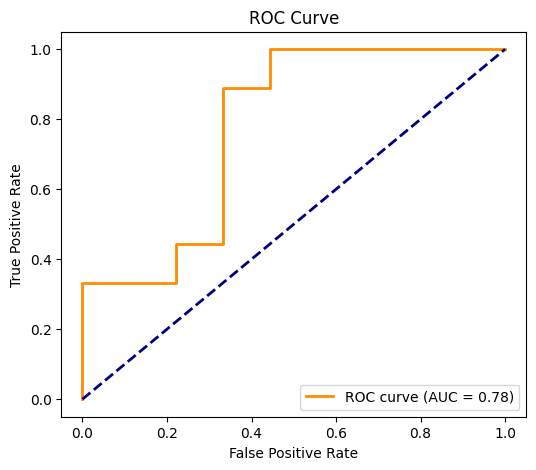

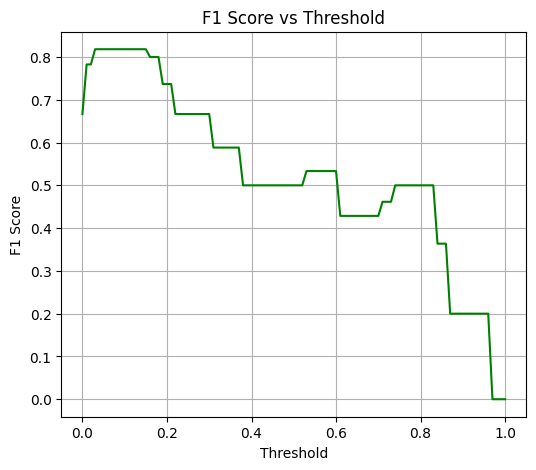


FP Reduction: 3
Cost Reduction: 3.00
Saved failure cases to CSV.


In [ ]:
# =========================
# 0️⃣ Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1️⃣ Load Metadata
# =========================
metadata_path = "/content/metadata.csv"
df = pd.read_csv(metadata_path)
df.columns = df.columns.str.strip()

# Binary labels: 1 = Malignant, 0 = Benign
df['label'] = 1  # all current samples are malignant

# =========================
# 2️⃣ Simulate benign samples (for testing pipeline)
# =========================
num_benign = len(df)  # simulate equal number of benign samples
df_benign = df.sample(num_benign, replace=True).copy()
df_benign['label'] = 0
df_benign['clin_size_long_diam_mm'] = df_benign['clin_size_long_diam_mm'].fillna(1.0)  # ensure small lesions
df_balanced = pd.concat([df, df_benign], ignore_index=True)

print("Balanced class distribution (simulated benign):")
print(df_balanced['label'].value_counts())

# =========================
# 3️⃣ Split Data
# =========================
train_df, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label'])
val_labels = val_df['label'].values

# =========================
# 4️⃣ Simulate Model Predictions
# Replace with actual model outputs in real use
# =========================
np.random.seed(42)
val_probs = np.random.rand(len(val_labels))
val_df['pred_prob'] = val_probs

# =========================
# 5️⃣ Clinical Rule Engine
# Suppress low-value positives using lesion size
# =========================
def clinical_rule_engine(df, probs, lesion_col='clin_size_long_diam_mm', size_thresh=2.0):
    adjusted_probs = probs.copy()
    if lesion_col in df.columns:
        tiny_mask = df[lesion_col] < size_thresh
        adjusted_probs[tiny_mask.fillna(False)] = 0.0
    return adjusted_probs

val_probs_adjusted = clinical_rule_engine(val_df, val_probs)

# =========================
# 6️⃣ Cost-Aware Thresholding
# =========================
def compute_cost(y_true, y_pred, C_FP=1.0, C_FN=5.0):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    total_cost = C_FP*fp + C_FN*fn
    return total_cost, (tn, fp, fn, tp)

def find_best_threshold(y_true, probs, C_FP=1.0, C_FN=5.0):
    thresholds = np.linspace(0, 1, 101)
    best_thresh, best_cost = 0.0, float('inf')
    for t in thresholds:
        preds = (probs >= t).astype(int)
        cost, _ = compute_cost(y_true, preds, C_FP, C_FN)
        if cost < best_cost:
            best_cost = cost
            best_thresh = t
    return best_thresh, best_cost

C_FP, C_FN = 1.0, 5.0
best_t_before, cost_before = find_best_threshold(val_labels, val_probs, C_FP, C_FN)
best_t_after, cost_after = find_best_threshold(val_labels, val_probs_adjusted, C_FP, C_FN)
print(f"Best threshold BEFORE rules: {best_t_before:.2f}, cost: {cost_before:.2f}")
print(f"Best threshold AFTER rules: {best_t_after:.2f}, cost: {cost_after:.2f}")

# =========================
# 7️⃣ Evaluation Function
# =========================
def evaluate(y_true, probs, threshold, df_val, title="Confusion Matrix"):
    y_pred = (probs >= threshold).astype(int)

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    labels_names = ['Benign (0)', 'Malignant (1)']

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title + f" (Threshold={threshold:.2f})")
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=labels_names))

    # Confusion + cost
    cost, (tn, fp, fn, tp) = compute_cost(y_true, y_pred, C_FP, C_FN)
    print(f"FP: {fp}, FN: {fn}, TP: {tp}, TN: {tn}, Total cost: {cost:.2f}")

    # Extract failure cases
    failures_df = df_val[y_pred != y_true]

    return fp, cost, failures_df

# BEFORE rules
print("=== BEFORE RULE ENGINE ===")
fp_before, cost_before, failures_before_df = evaluate(val_labels, val_probs, best_t_before, val_df, title="Before Rules")

# AFTER rules
print("\n=== AFTER RULE ENGINE ===")
fp_after, cost_after, failures_after_df = evaluate(val_labels, val_probs_adjusted, best_t_after, val_df, title="After Rules")

print(f"\nFP Reduction: {fp_before - fp_after}")
print(f"Cost Reduction: {cost_before - cost_after:.2f}")

# Save failure cases
failures_after_df.to_csv("/content/failure_cases_after.csv", index=False)
failures_before_df.to_csv("/content/failure_cases_before.csv", index=False)
print("Saved failure cases to CSV.")

from sklearn.metrics import roc_curve, auc, f1_score

# =========================
# 7️⃣ Evaluation Function + Curves
# =========================
def evaluate_with_curves(y_true, probs, threshold, df_val, title="Confusion Matrix"):
    y_pred = (probs >= threshold).astype(int)

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    labels_names = ['Benign (0)', 'Malignant (1)']
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title + f" (Threshold={threshold:.2f})")
    plt.show()

    # ---- Classification Report ----
    print(classification_report(y_true, y_pred, target_names=labels_names))

    # ---- Confusion + cost ----
    cost, (tn, fp, fn, tp) = compute_cost(y_true, y_pred, C_FP, C_FN)
    print(f"FP: {fp}, FN: {fn}, TP: {tp}, TN: {tn}, Total cost: {cost:.2f}")

    # ---- ROC Curve ----
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # ---- F1 Score vs Threshold Curve ----
    thresholds = np.linspace(0, 1, 101)
    f1_scores = [f1_score(y_true, (probs >= t).astype(int)) for t in thresholds]
    plt.figure(figsize=(6,5))
    plt.plot(thresholds, f1_scores, color='green')
    plt.title('F1 Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()

    # ---- Failure Cases ----
    failures_df = df_val[y_pred != y_true]
    return fp, cost, failures_df

# ---- Run Evaluations ----
print("=== BEFORE RULE ENGINE ===")
fp_before, cost_before, failures_before_df = evaluate_with_curves(val_labels, val_probs, best_t_before, val_df, title="Before Rules")

print("\n=== AFTER RULE ENGINE ===")
fp_after, cost_after, failures_after_df = evaluate_with_curves(val_labels, val_probs_adjusted, best_t_after, val_df, title="After Rules")

print(f"\nFP Reduction: {fp_before - fp_after}")
print(f"Cost Reduction: {cost_before - cost_after:.2f}")

# Save failure cases
failures_after_df.to_csv("/content/failure_cases_after.csv", index=False)
failures_before_df.to_csv("/content/failure_cases_before.csv", index=False)
print("Saved failure cases to CSV.")


In [ ]:
#